In [2]:
!pip install swig

In [3]:
!pip install gymnasium

In [4]:
!pip install gymnasium[box2d]

# Experiment 1

## 1. Apply standard DQN. Decide on the design choices in your code (e.g., network architecture) and perform hyperparameter tuning on at least two parameters of your models.

In [5]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

In [17]:



GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.997
TARGET_UPDATE_FREQ = 5


learning_rates = [0.0005, 0.001, 0.01]
hidden_sizes = [64, 128, 256]

Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():
    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, info = self.env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                obs, info = self.env.reset()
        return self

class DQN(nn.Module):
    def __init__(self, ninputs, noutputs, hidden_size):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, hidden_size)
        self.a2 = nn.Linear(hidden_size, noutputs)

    def forward(self, X):
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        return o

    def __call__(self, X):
        return self.forward(X)

def epsilon_greedy_policy(epsilon, obs, dqn_policy, env):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action

env = gym.make("LunarLander-v3")

def train(learning_rate, hidden_size):
    obs, info = env.reset()
    eps_threshold = EPS_START
    episode = 1
    episode_reward = 0.0
    all_rewards = []  

    replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

    dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n, hidden_size)
    dqn_target = DQN(env.observation_space.shape[0], env.action_space.n, hidden_size)
    dqn_target.load_state_dict(dqn_policy.state_dict())
    dqn_target.eval()

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

    for step in itertools.count():
        action = epsilon_greedy_policy(eps_threshold, obs, dqn_policy, env)
        new_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_memory.append(Transition(obs, action, reward, done, new_obs))
        episode_reward += reward
        obs = new_obs

        if done:
            episode += 1
            eps_threshold = np.max((eps_threshold * EPS_DECAY, EPS_END))
            replay_memory.rewards.append(episode_reward)
            obs, info = env.reset()
            avg_res = np.mean(replay_memory.rewards)
            all_rewards.append(avg_res)

            if episode % 50 == 0:
                print(f'Episode: {episode} Avg Results: {avg_res:.2f} Epsilon: {eps_threshold:.3f}')

            if len(replay_memory.rewards) == 50 and avg_res >= 195:
                print(f'Solved at episode: {episode} Avg Results: {avg_res:.2f}')
                break

            if episode >= 2000:  
                print(f'Did not solve within 2000 episodes. Final avg reward: {avg_res:.2f}')
                break
            episode_reward = 0

        b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

        qvalues = dqn_policy(b_states).gather(1, b_actions)

        with torch.no_grad():
            target_qvalues = dqn_target(b_next_states)
            max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
            expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

        loss = loss_fn(qvalues, expected_qvalues)
        optimizer.zero_grad()
        loss.backward()
        for param in dqn_policy.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

        if episode % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

    return all_rewards, dqn_policy


results = []
models = {}

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        print(f"\nTraining with learning_rate={lr}, hidden_size={hidden_size}")
        all_rewards, model = train(lr, hidden_size)
        
        
        solved_episode = None  
        final_avg_reward = np.mean(all_rewards[-50:])  
        
        
        for i in range(50, len(all_rewards)):
            if np.mean(all_rewards[i-50:i]) >= 195:
                solved_episode = i
                break
        
        results.append({
            'learning_rate': lr,
            'hidden_size': hidden_size,
            'episodes_to_solve': solved_episode if solved_episode else float('inf'),  
            'avg_reward': final_avg_reward
        })
        models[(lr, hidden_size)] = model


Training with learning_rate=0.0005, hidden_size=64
Episode: 50 Avg Results: -186.84 Epsilon: 0.777
Episode: 100 Avg Results: -184.86 Epsilon: 0.668
Episode: 150 Avg Results: -122.89 Epsilon: 0.575
Episode: 200 Avg Results: -102.71 Epsilon: 0.495
Episode: 250 Avg Results: -132.10 Epsilon: 0.426
Episode: 300 Avg Results: -120.16 Epsilon: 0.367
Episode: 350 Avg Results: -79.88 Epsilon: 0.315
Episode: 400 Avg Results: -23.48 Epsilon: 0.271
Episode: 450 Avg Results: 46.27 Epsilon: 0.234
Episode: 500 Avg Results: 139.11 Epsilon: 0.201
Episode: 550 Avg Results: 142.13 Epsilon: 0.173
Episode: 600 Avg Results: 147.96 Epsilon: 0.149
Solved at episode: 635 Avg Results: 196.47

Training with learning_rate=0.0005, hidden_size=128
Episode: 50 Avg Results: -226.83 Epsilon: 0.777
Episode: 100 Avg Results: -117.52 Epsilon: 0.668
Episode: 150 Avg Results: -93.48 Epsilon: 0.575
Episode: 200 Avg Results: -84.12 Epsilon: 0.495
Episode: 250 Avg Results: -59.92 Epsilon: 0.426
Episode: 300 Avg Results: -15.6

From these results, the hidden_size of 128 and learning rate of 0.001 needed the least amount of episodes to achieve the avrage result of 195 in the last 50 episodes (621 episodes). These values will now be used to continue this experiment.

In [19]:

best_lr = 0.001
best_hidden_size = 128
best_model = models[(best_lr, best_hidden_size)]
torch.save(best_model.state_dict(), 'standard_dqn.pth')


standard_model = DQN(env.observation_space.shape[0], env.action_space.n, hidden_size=128)
standard_model.load_state_dict(torch.load('standard_dqn.pth'))
standard_model.eval()


obs, _ = env.reset()
total_reward = 0
done = False

while not done:
    with torch.no_grad():
        action = int(torch.argmax(standard_model(torch.Tensor(obs))))
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

print(f"Test episode reward for standard DQN: {total_reward:.2f}")

Test episode reward for standard DQN: 132.79


## 2. Apply one improvement to the standard DQN (apply separately) and compare/discuss against the standard DQN. Compare the new model against the standard DQN.

For this, I will use Double DQN as the DQN improvement

In [13]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")


GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.997
TARGET_UPDATE_FREQ = 5
learning_rate = 0.001  

Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():
    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, info = self.env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                obs, info = self.env.reset()
        return self

class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 128)  
        self.a2 = nn.Linear(128, noutputs)

    def forward(self, X):
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        return o

    def __call__(self, X):
        return self.forward(X)

def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action


env = gym.make("LunarLander-v3")
obs, info = env.reset()
episode_reward = 0.0


replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()


dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)


def train():
    obs, info = env.reset()
    eps_threshold = EPS_START
    episode = 1
    episode_reward = 0.0
    all_rewards = []  

    for step in itertools.count():
        action = epsilon_greedy_policy(eps_threshold, obs)
        new_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_memory.append(Transition(obs, action, reward, done, new_obs))
        episode_reward += reward
        obs = new_obs

        if done:
            episode += 1
            eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
            replay_memory.rewards.append(episode_reward)
            obs, info = env.reset()
            avg_res = np.mean(replay_memory.rewards)
            all_rewards.append(avg_res)

            if episode % 50 == 0:
                print(f'Episode: {episode} Avg Results: {avg_res:.2f} Epsilon: {eps_threshold:.3f}')

            if len(replay_memory.rewards) == 50 and avg_res >= 195:
                print(f'Solved at episode: {episode} Avg Results: {avg_res:.2f}')
                break
            episode_reward = 0

        b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

        qvalues = dqn_policy(b_states).gather(1, b_actions)

        
        with torch.no_grad():
            _, next_actions = dqn_policy(b_next_states).max(dim=1, keepdim=True)    
            next_action_values = dqn_target(b_next_states).gather(1, next_actions)   
            expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * next_action_values

        loss = loss_fn(qvalues, expected_qvalues)
        optimizer.zero_grad()
        loss.backward()
        for param in dqn_policy.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

        if episode % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

    return all_rewards, dqn_policy

In [14]:
rewards, double_model = train()

torch.save(double_model.state_dict(), 'double_dqn.pth')


obs, _ = env.reset()
total_reward = 0
done = False

while not done:
    with torch.no_grad():
        action = int(torch.argmax(double_model(torch.Tensor(obs))))
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

print(f"Test episode reward for Double DQN: {total_reward:.2f}")

Episode: 50 Avg Results: -163.60 Epsilon: 0.777
Episode: 100 Avg Results: -122.62 Epsilon: 0.668
Episode: 150 Avg Results: -59.89 Epsilon: 0.575
Episode: 200 Avg Results: -67.59 Epsilon: 0.495
Episode: 250 Avg Results: -80.97 Epsilon: 0.426
Episode: 300 Avg Results: -38.70 Epsilon: 0.367
Episode: 350 Avg Results: 68.16 Epsilon: 0.315
Episode: 400 Avg Results: 81.25 Epsilon: 0.271
Episode: 450 Avg Results: 34.97 Epsilon: 0.234
Episode: 500 Avg Results: 113.32 Epsilon: 0.201
Episode: 550 Avg Results: 125.36 Epsilon: 0.173
Episode: 600 Avg Results: 165.82 Epsilon: 0.149
Episode: 650 Avg Results: 162.43 Epsilon: 0.128
Solved at episode: 666 Avg Results: 200.05
Test episode reward for Double DQN: 229.92


## 3. As a key objective for this experiment you are asked to investigate how varying degrees of noise (in the state), say HIGH-MEDIUM-LOW, impact the trained DQN models in different ways, providing deeper insights into model robustness. By comparing performance at multiple noise levels, explore how sensitive/resistant each of the two models is to increasing noise.

In [11]:
import torch

def inject_gaussian_noise(state, noise_level=0.1):
  """

  Injects Gaussian noise into the given state tensor

  Parameters:
  - state (torch.Tensor): The original state tensor
  - noise_level (float): The standard deviation of the Gaussian noise to inject.

  Returns:
  - torch.Tensor: The state tensor with added Gaussian Noise
  """
  #Ensure state is a torch tensor
  if not isinstance(state, torch.Tensor):
    state = torch.tensor(state, dtype=torch.float32)

  # Generate Gaussian noise and inject it into the state
  noise = torch.randn(state.size()) * noise_level
  noisy_state = state + noise
  return noisy_state

In [8]:
NOISE_LEVELS = {
    'LOW': 0.05,
    'MEDIUM': 0.15,
    'HIGH': 0.25
}

In [10]:
def evaluate_model_with_noise(model, noise_level, num_episodes=100):
    rewards = []
    env = gym.make("LunarLander-v3")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            
            noisy_obs = inject_gaussian_noise(obs, noise_level)

            
            with torch.no_grad():
                noisy_obs_tensor = torch.FloatTensor(noisy_obs)
                action = int(torch.argmax(model(noisy_obs_tensor)))

            
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        rewards.append(episode_reward)

    return np.mean(rewards), np.std(rewards)


def compare_model_robustness(standard_dqn, double_dqn):
    results = {
        'standard': {},
        'double': {}
    }

    for noise_name, noise_level in NOISE_LEVELS.items():
        print(f"\nTesting with {noise_name} noise (σ={noise_level})")

        
        std_mean, std_std = evaluate_model_with_noise(standard_dqn, noise_level)
        results['standard'][noise_name] = (std_mean, std_std)
        print(f"Standard DQN - Mean reward: {std_mean:.2f} ± {std_std:.2f}")

        
        dbl_mean, dbl_std = evaluate_model_with_noise(double_dqn, noise_level)
        results['double'][noise_name] = (dbl_mean, dbl_std)
        print(f"Double DQN - Mean reward: {dbl_mean:.2f} ± {dbl_std:.2f}")

    return results


def plot_robustness_comparison(results):
    noise_levels = list(NOISE_LEVELS.keys())
    standard_means = [results['standard'][level][0] for level in noise_levels]
    double_means = [results['double'][level][0] for level in noise_levels]
    standard_stds = [results['standard'][level][1] for level in noise_levels]
    double_stds = [results['double'][level][1] for level in noise_levels]

    plt.figure(figsize=(10, 6))
    x = np.arange(len(noise_levels))
    width = 0.35

    plt.bar(x - width/2, standard_means, width, label='Standard DQN', yerr=standard_stds, capsize=5)
    plt.bar(x + width/2, double_means, width, label='Double DQN', yerr=double_stds, capsize=5)

    plt.xlabel('Noise Level')
    plt.ylabel('Average Reward')
    plt.title('Model Performance Under Different Noise Levels')
    plt.xticks(x, noise_levels)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Testing with LOW noise (σ=0.05)
Standard DQN - Mean reward: 146.10 ± 77.48
Double DQN - Mean reward: 81.80 ± 114.83

Testing with MEDIUM noise (σ=0.15)
Standard DQN - Mean reward: 49.70 ± 68.59
Double DQN - Mean reward: -22.45 ± 126.69

Testing with HIGH noise (σ=0.25)
Standard DQN - Mean reward: 11.06 ± 41.21
Double DQN - Mean reward: -63.32 ± 116.09


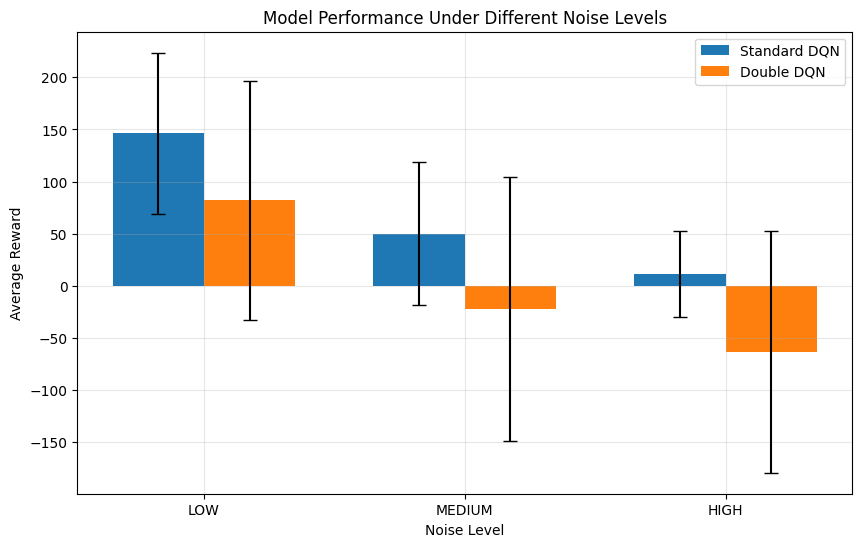

In [22]:

env = gym.make("LunarLander-v3")
n_observations = env.observation_space.shape[0]
n_actions = 4  


standard_model = DQN(n_observations, n_actions, hidden_size=128)  
standard_model.load_state_dict(torch.load('standard_dqn.pth'))
standard_model.eval()

double_model = DQN(n_observations, n_actions, hidden_size=128)  
double_model.load_state_dict(torch.load('double_dqn.pth'))
double_model.eval()


results = compare_model_robustness(standard_model, double_model)


plot_robustness_comparison(results)